Printing Plots


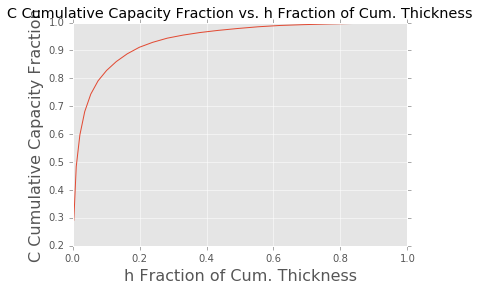

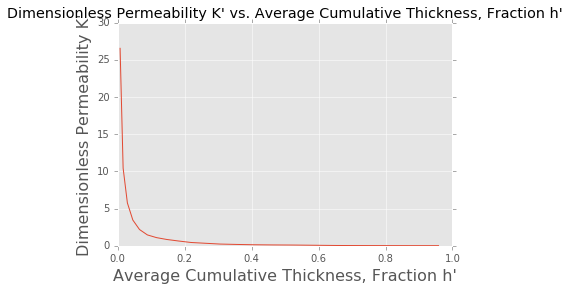

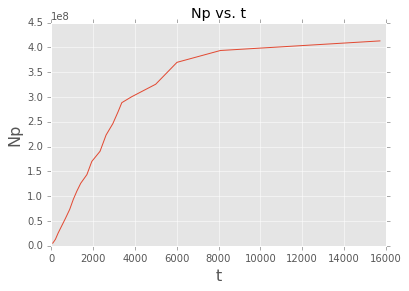

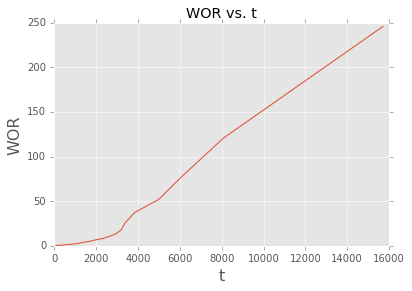

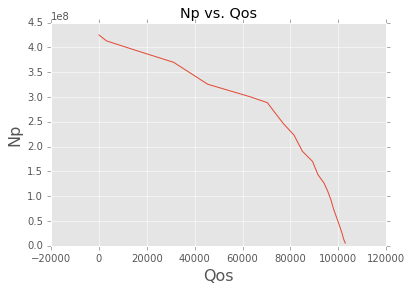

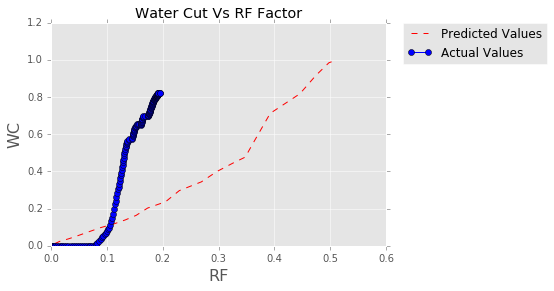

Starting to export to excel
Finished exporting


In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go
from datetime import datetime

plotly.offline.init_notebook_mode()

%matplotlib inline
plt.style.use('ggplot')


def plotFunction(x, y):
    temp_figure = plt.figure()
    plt.plot(x, y)
    plt.title(y.name + " vs. " + x.name)
    plt.xlabel(x.name, fontsize=16)
    plt.ylabel(y.name, fontsize=16)
    plt.show()

# READ RAW CORE DATA
raw_data = pd.read_csv(r"C:\Users\jenng\OneDrive\School\Class of 2017 (UT)\Misc\PGE 323L -  Reservoir II\Homework\RawData.csv", sep=',',header=0)

# READ PRODUCTION DATA

# THE NUMERICAL PRODUCTION DATA FOR OIL & WATER IS OBTAINED
# FROM SLIDE 21 OF Terary N2 MGI - Jay Field PPT
# USING http://arohatgi.info/WebPlotDigitizer

prod_data = pd.read_csv(r"C:\Users\jenng\OneDrive\School\Class of 2017 (UT)\Misc\PGE 323L -  Reservoir II\Homework\Homework 10\JayFieldProdInjectExtrapolatedData.csv", sep=',',header=0)

qo_data = pd.concat([prod_data['Date - Qo'], prod_data['Qo']], axis=1, keys=['Date - Qo', 'Qo'])
qw_data = pd.concat([prod_data['Date - Qw'], prod_data['Qw']], axis=1, keys=['Date - Qw', 'Qw'])


# AVERAGE Qo & Qw READ FROM THE GRAPH INTO MONTHLY VALUES
qo_data['Date - Qo'] = pd.to_datetime(qo_data['Date - Qo'], format='%m/%d/%Y')
qw_data['Date - Qw'] = pd.to_datetime(qw_data['Date - Qw'], format='%m/%d/%Y')
qo_data = qo_data.set_index('Date - Qo').resample('M', how='mean')
qw_data = qw_data.set_index('Date - Qw').resample('M', how='mean')
qo_data = qo_data.dropna()
qw_data = qw_data.dropna()

# PREPARE MONTH & YEAR FOR JOINING TABLES
qo_data['Month'] = qo_data.index.month
qo_data['Year'] = qo_data.index.year

qw_data['Month'] = qw_data.index.month
qw_data['Year'] = qw_data.index.year

# INNJER JOIN THE DATA FRAMES USING MONTH & YEAR
prod_data = pd.merge(qo_data,qw_data, on=['Month','Year'])

# CONSTANTS 
A = 14400
h = 87
phi = .14
Soi = .8988
OOIP = 830e6
Sor = .159
Ea = .82
Bo = 1.93
Bw = 1
Mo = .2
krw = .593
kro = .43
mu_o = .18
mu_w = 1.241
iw = 200000
A_constant = (krw*mu_o*Bo)/(kro*mu_w*Bw)

# RE-INDEXING THE ROWS FOR GROUPING
a = raw_data.index.values
idx = np.array([a, a, a]).T.flatten()[:len(a)]

# AVERAGE EVERY 3 ROWS FROM THE ORIGINAL RAW_DATA TO THE NEW DATA SET
data = raw_data.groupby(idx).mean()

# GET THE DIMENSIONS OF THE NEW DATA FRAME
total_rows=len(data.axes[0])
total_cols=len(data.axes[1])

# DELETE FIRST 2 COLUMNS Core & No.
data = data.drop('Core', 1)
data = data.drop('No.', 1)



# ANALYZE AND CALCULATE THE CORE DATA
data['Cum. Thickness Feet'] = (np.linspace(1, total_rows, total_rows))
total_thickness = sum(data['Cum. Thickness Feet'])
data['h Fraction of Cum. Thickness'] = data['Cum. Thickness Feet'].cumsum()/total_thickness
data['kΔh Permeability Capacity'] = data['k (md)']*1
data['ΔC Increment of Total Capacity'] = data['kΔh Permeability Capacity']/sum(data['kΔh Permeability Capacity'])
data['C Cumulative Capacity Fraction'] = data['ΔC Increment of Total Capacity'].cumsum()
data['Increment of Cum. Thickness Δh'] = data['h Fraction of Cum. Thickness']  - data['h Fraction of Cum. Thickness'].shift(+1).set_value(0, 0.00)
data['Increment of Cum Capacity ΔC'] = data['C Cumulative Capacity Fraction'] - data['C Cumulative Capacity Fraction'].shift(+1).set_value(0, 0.00)
data['Dimensionless Permeability K\'']= data['Increment of Cum Capacity ΔC']/data['Increment of Cum. Thickness Δh']
data['Average Cumulative Thickness, Fraction h\'']= (data['h Fraction of Cum. Thickness'] + data['h Fraction of Cum. Thickness'].shift(+1))/2
data['Cv']= ((data['Dimensionless Permeability K\''] * data['h Fraction of Cum. Thickness']) + (1-data['C Cumulative Capacity Fraction']))/data['Dimensionless Permeability K\'']
data['Np']= (7758*A*h*phi*(Soi-Sor)*Ea/Bo)*data['Cv']
data['WCs']= (A_constant *data['Cv'].shift(-1))/(A_constant*data['Cv'].shift(-1)+(1-data['Cv'].shift(-1)))
data['WCr']= (Mo *data['Cv'].shift(-1))/(Mo*data['Cv'].shift(-1)+(1-data['Cv'].shift(-1)))
data['Qos']= (iw*(1-data['WCr']))/Bo
data['Qos,avg']= (data['Qos'] + data['Qos'].shift(-1))/2
data['ΔNp'] = data['Np'].shift(-1)-data['Np']
data['Δt'] = data['ΔNp']/data['Qos,avg']
tf = 0
data['t'] = tf + data['Δt'].cumsum()
data['Wi'] = iw*data['t']
data['WOR'] = (data['C Cumulative Capacity Fraction'].shift(-1)*.386)/(1-data['C Cumulative Capacity Fraction'].shift(-1))
data['RF Predicted'] = data['Np']/OOIP

# ANALYZE AND CALCULATE THE PRODUCTION DATA

prod_data['Monthly Oil Produced'] = compared_data['Qo']*30
prod_data['Cumulative Oil Produced'] = prod_data['Monthly Oil Produced'].cumsum()
prod_data['RF Actual'] = prod_data['Cumulative Oil Produced']/OOIP
prod_data['Monthly Water Produced'] = compared_data['Qw']*30
prod_data['Cumulative Water Produced'] = prod_data['Monthly Water Produced'].cumsum()
prod_data['WC Actual'] = prod_data['Cumulative Water Produced']/(prod_data['Cumulative Water Produced']+prod_data['Cumulative Oil Produced'])

# ROUND DECIMALS
data.round(3)
prod_data.round(3)

# PLOT FIGURES

print("Printing Plots")

plotFunction(data['h Fraction of Cum. Thickness'], data['C Cumulative Capacity Fraction'])
plotFunction(data['Average Cumulative Thickness, Fraction h\''], data['Dimensionless Permeability K\''])
plotFunction(data['t'], data['Np'])
plotFunction(data['t'], data['WOR'])
plotFunction(data['Qos'], data['Np'])

plt.figure()
plt.plot(data['RF Predicted'],data['WCs'], 'r--', label='Predicted Values')
plt.plot(prod_data['RF Actual'], prod_data['WC Actual'], 'bo-', label='Actual Values')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Water Cut Vs RF Factor")
plt.xlabel("RF", fontsize=16)
plt.ylabel("WC", fontsize=16)
plt.show()
    
print("Starting to export to excel")
writer = pd.ExcelWriter(r'C:\Users\jenng\OneDrive\School\Class of 2017 (UT)\Misc\PGE 323L -  Reservoir II\Homework\Homework 10\Final Results.xlsx')
data.to_excel(writer, 'Predicted From Core')
prod_data.to_excel(writer, 'Actual From Graph')
writer.save()
print("Finished exporting")


